In [ ]:
%load_ext autoreload
import osmnx as ox
import os
from pathlib import Path
from tqdm import tqdm
import warnings
import boto3
from s3_client import S3ClientHandler
from datetime import date
import random 
import geopandas as gpd
import time
import random
import pandas as pd

In [67]:
client = S3ClientHandler()

Permissions verified for bucket: amenities-dataset


In [5]:
# FOR JOJIE
# CACHE_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/cache')
# LOGS_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/logs')

# For cache
CACHE_DIR = Path('./cache')
LOGS_DIR = Path('./logs')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

In [6]:
# OSMNX Settings
ox.settings.use_cache = True
ox.settings.log_console = True
ox.settings.cache_folder = CACHE_DIR
ox.settings.data_folder = None # Change to S3
ox.settings.logs_folder = LOGS_DIR
ox.settings.log_file = True

ox.settings.default_crs = "epsg:4326"
ox.settings.requests_timeout = 1000
ox.settings.max_query_area_size = 2500000000

AMENITY_RADIUS = 6000

## Get List of Provinces

In [ ]:
provinces = pd.read_excel('PSGC-1Q-2025-National-and-Provincial-Summary.xlsx').dropna()
provinces = provinces.iloc[:, :2]

provinces.columns = ['psgc_code', 'name']

provinces["region"] = provinces['name'].where(provinces['name'].str.contains('Region'))
provinces = provinces[(~provinces['name'].str.contains('NAME'))]
provinces['region'] = provinces['region'].ffill()

provinces = provinces[provinces['name'] != provinces['region']]

Geodataframe does not exist. Proceeding to geocode provinces.
Error geocoding Lanao del Sur, Bangsamoro Autonomous Region in Muslim Mindanao (BARMM), Philippines: Nominatim did not geocode query 'Lanao del Sur, Bangsamoro Autonomous Region in Muslim Mindanao (BARMM), Philippines' to a geometry of type (Multi)Polygon.. Trying mitigating steps.
Uploaded amenities to s3://amenities-dataset/amenities_v2/provinces.geojson.geojson


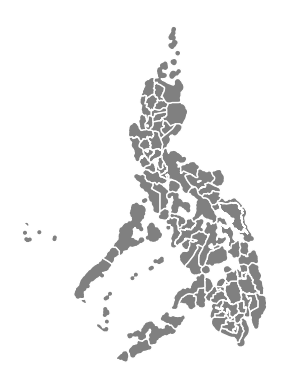

In [78]:
queries = [f"{province}, {region}, Philippines" for province, region in zip(provinces['name'], provinces['region'])]

if not client.check_geodataframe_exists("provinces.geojson", folder="amenities_v2"):
    print("Geodataframe does not exist. Proceeding to geocode provinces.")
    gdfs = []
    for province, region in zip(provinces['name'], provinces['region']):
        query = f"{province}, {region}, Philippines"

        # SPECIAL OVERRIDES SINCE OSMNX GEOCODER IS NOT WORKING FOR THESE PROVINCES
        if province in ["Maguindanao del Sur","Sulu"]:
            query = f"{province}, Philippines"
        if province in ["Pasay City"]:
            query = "Pasay, National Capital Region (NCR), Philippines"
        if "Special Geographic Area" in query:
            continue
        
        query = query.replace("City of ", "")
        
        try:
            gdf = ox.geocoder.geocode_to_gdf(query)
        except Exception as e:
            print(f"Error geocoding {query}: {e}. Trying mitigating steps.")
            query = f"{province}, Philippines"
            query = query.replace("Province of ", "")
            gdf = ox.geocoder.geocode_to_gdf(query)

        gdf["query"] = query

        gdf["province__raw"] = province
        gdf["region__raw"] = region
        gdfs.append(gdf)

    provinces_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")

    client.upload_geodataframe(
        provinces_gdf,
        file_name="provinces.geojson",
        folder="amenities_v2",
    )
else:
    print("Geodataframe already exists. Loading from S3.")
    provinces_gdf = client.get_geodataframe(
        file_name="provinces.geojson",
        folder="amenities_v2",
    )
        
mx_gt_tx = ox.projection.project_gdf(provinces_gdf, to_crs=3857)
ax = mx_gt_tx.plot(fc="gray", ec="w")
_ = ax.axis("off")

## Get Provincial Features

In [73]:
FEATURES_TO_RETAIN = ['building','amenity','leisure','public_transport','office','shop','tourism','name','geometry']
tags = {"building": True, "amenity": True, "leasure": True, "public_transport": True, "office": True, "shop": True, "tourism": True, }

In [76]:
snapshot_dates = [
    date(year, month, 1)
    for year in range(2023, 2017, -1)
    for month in (1, 4, 7, 10)  # January, April, July, October
]

print("Snapshot dates:")
for snapshot_date in snapshot_dates:
    print(snapshot_date.strftime("%Y-%m-%d"))

Snapshot dates:
2023-01-01
2023-04-01
2023-07-01
2023-10-01
2022-01-01
2022-04-01
2022-07-01
2022-10-01
2021-01-01
2021-04-01
2021-07-01
2021-10-01
2020-01-01
2020-04-01
2020-07-01
2020-10-01
2019-01-01
2019-04-01
2019-07-01
2019-10-01
2018-01-01
2018-04-01
2018-07-01
2018-10-01


In [79]:
provinces_gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,query,province__raw,region__raw
0,"MULTIPOLYGON (((120.96064 14.64334, 120.96141 ...",120.960643,14.635560,121.099061,14.785336,240582443,relation,273242,14.651348,120.972400,boundary,administrative,12,0.506670,city,Caloocan,"Caloocan, Northern Manila District, Metro Mani...","Caloocan, National Capital Region (NCR), Phili...",City of Caloocan,National Capital Region (NCR)
1,"POLYGON ((120.94335 14.49391, 120.96889 14.476...",120.943353,14.349186,121.024204,14.501115,400752391,relation,2095594,14.480901,120.981786,boundary,administrative,12,0.498591,city,Las Piñas,"Las Piñas, Southern Manila District, Metro Man...","Las Piñas, National Capital Region (NCR), Phil...",City of Las Piñas,National Capital Region (NCR)
2,"POLYGON ((120.99877 14.56176, 120.9989 14.5616...",120.998771,14.529651,121.050072,14.579432,240475904,relation,103716,14.556795,121.021123,boundary,administrative,12,0.545342,city,Makati,"Makati, Southern Manila District, Metro Manila...","Makati, National Capital Region (NCR), Philipp...",City of Makati,National Capital Region (NCR)
3,"POLYGON ((120.921 14.69926, 120.92207 14.69773...",120.921000,14.645056,121.000417,14.704413,240526735,relation,403176,14.657850,120.951126,boundary,administrative,12,0.487127,city,Malabon,"Malabon, Northern Manila District, Metro Manil...","Malabon, National Capital Region (NCR), Philip...",City of Malabon,National Capital Region (NCR)
4,"POLYGON ((121.01707 14.58061, 121.01728 14.579...",121.017070,14.567208,121.060063,14.601953,240345147,relation,2284209,14.577439,121.033897,boundary,administrative,12,0.508976,city,Mandaluyong,"Mandaluyong, Eastern Manila District, Metro Ma...","Mandaluyong, National Capital Region (NCR), Ph...",City of Mandaluyong,National Capital Region (NCR)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,"POLYGON ((123.84653 7.56269, 123.8485 7.56199,...",123.846526,7.439066,124.828594,8.123670,238715142,relation,1513166,7.877644,124.375476,boundary,administrative,8,0.522042,state,Lanao del Sur,"Lanao del Sur, Bangsamoro, Philippines","Lanao del Sur, Philippines",Lanao del Sur,Bangsamoro Autonomous Region in Muslim Mindana...
113,"POLYGON ((123.80763 6.82019, 123.80766 6.81504...",123.807634,6.659724,124.492834,7.654154,241170210,relation,14595842,7.108836,124.207295,boundary,administrative,8,0.417315,state,Maguindanao del Norte,"Maguindanao del Norte, Bangsamoro, Philippines","Maguindanao del Norte, Bangsamoro Autonomous R...",Maguindanao del Norte,Bangsamoro Autonomous Region in Muslim Mindana...
114,"POLYGON ((124.07354 6.76278, 124.12165 6.76278...",124.073541,6.634280,124.979779,7.203407,241156505,relation,1513165,6.923420,124.536536,boundary,administrative,8,0.420147,state,Maguindanao del Sur,"Maguindanao del Sur, Bangsamoro, Philippines","Maguindanao del Sur, Philippines",Maguindanao del Sur,Bangsamoro Autonomous Region in Muslim Mindana...
115,"POLYGON ((119.51643 5.83068, 119.51664 5.82516...",119.516428,5.315267,122.084435,6.574638,240830598,relation,1513292,5.994281,121.078793,boundary,administrative,8,0.536224,state,Sulu,"Sulu, Zamboanga Peninsula, Philippines","Sulu, Philippines",Sulu,Bangsamoro Autonomous Region in Muslim Mindana...


In [ ]:
filename = ''
def crawl(provinces_gdf: gpd.GeoDataFrame):
    random.shuffle(snapshot_dates)
    for snapshot_date in snapshot_dates.copy():
        snapshot__str = snapshot_date.strftime("%Y-%m-%dT%H:%M:%SZ")
        print(snapshot__str)
        ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{snapshot__str}"]{{maxsize}}'
        print(ox.settings.overpass_settings)

        provinces_gdf = provinces_gdf.sample(frac=1)

        for idx, row in (pbar := tqdm(provinces_gdf.iterrows(), total=len(provinces_gdf), desc="Processing provinces")):
            province = row['province__raw']
            region = row['region__raw']
            geometry = row['geometry']
            
            global filename
            filename = f"date={snapshot_date.strftime("%Y-%m-%d")}/region={region}/{province}"
    
            if client.check_geodataframe_exists(filename, folder="amenities_v2"):
                # print(f"File {filename} already exists. Skipping...")
                gdf = client.get_geodataframe(filename)

                display(gdf)

                continue
            pbar.set_description(f"Processing {province},{region}")

            gdf = ox.features.features_from_polygon(polygon=geometry, tags=tags)
            

            existing_columns = [col for col in FEATURES_TO_RETAIN if col in gdf.columns]
            gdf = gdf[existing_columns]
            gdf['region'] = region
            gdf['province'] = province

            pbar.set_description(f"Saving {region}, {province} - {len(gdf)} features")

            client.upload_geodataframe(gdf, filename, folder="amenities_v2")

        # remove the snapshot date from the list
        snapshot_dates.remove(snapshot_date)

while True:
    try:
        crawl(provinces_gdf)
        break
    except Exception as e:
        # raise e
        print(f"Error: {e}")
        print("Retrying in 5 seconds...")
        time.sleep(5)

2020-04-01T00:00:00Z
[out:json][timeout:{timeout}][date:"2020-04-01T00:00:00Z"]{maxsize}


Processing Capiz,Region VI  (Western Visayas):   1%|          | 1/117 [04:05<7:54:19, 245.34s/it]                     

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Region XI (Davao Region)/Davao del Norte.geojson


Processing Iloilo,Region VI  (Western Visayas):   2%|▏         | 2/117 [07:09<6:41:28, 209.47s/it]              

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Region VI  (Western Visayas)/Capiz.geojson


Processing Apayao,Cordillera Administrative Region  (CAR):   3%|▎         | 3/117 [14:07<9:38:16, 304.35s/it]    

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Region VI  (Western Visayas)/Iloilo.geojson


Processing City of Davao,Region XI (Davao Region):   3%|▎         | 4/117 [33:24<20:07:25, 641.11s/it]                      

Uploaded amenities to s3://amenities-dataset/amenities/date=2020-04-01/region=Cordillera Administrative Region  (CAR)/Apayao.geojson


Processing City of Davao,Region XI (Davao Region):   3%|▎         | 4/117 [47:32<22:22:58, 713.08s/it]


Error: HTTPSConnectionPool(host='overpass-api.de', port=443): Read timed out. (read timeout=180)
Retrying in 5 seconds...
2018-01-01T00:00:00Z
[out:json][timeout:{timeout}][date:"2018-01-01T00:00:00Z"]{maxsize}


Processing Tarlac,Region III (Central Luzon):   0%|          | 0/117 [00:00<?, ?it/s]